In [33]:
#import libraries
import numpy as np 
import pandas as pd
import math 
import sys
import matplotlib.pyplot as plt
import random

In [34]:
columns_name = ['x1', 'x2', 'y']
df = pd.read_csv('data/Druns.txt', names = columns_name, sep = ' ')
df

,x1,x2,y
0,0.1,-2,0
1,0.0,-1,1
2,0.0,0,0
3,0.0,1,0
4,0.0,2,0
5,0.0,3,0
6,0.0,4,0
7,0.0,5,0
8,0.0,6,1
9,0.0,7,0


In [35]:
def entropy(y):
    prob = y.value_counts()/y.shape[0]
    entropy = np.sum(-prob*np.log2(prob)) #for prob not to be 0 in log
    return entropy

In [36]:
def info_gain(y, mask, func = entropy):
    a = sum(mask)
    b = mask.shape[0] - a
    if a == 0 or b == 0:
        return 0
    else:
        return func(y) - (func(y[mask])*a/(a+b) + func(y[-mask])*b/(a+b)) 


In [37]:
def info_gain_ratio(col, y, mask, func = info_gain):
    if entropy != 0:
        return func(y, mask)/entropy(mask)
    return None

In [38]:
def total_info_gain(x, y, func = entropy):
    options = x.sort_values().unique()
    res = []
    for value in options:
        mask = x >= value
        ig = info_gain_ratio(x, y, mask)
        res.append([value, ig])
    return res

In [39]:
colname = ['value', 'ig_ratio']
df1 = pd.DataFrame(total_info_gain(df["x1"], df["y"]))
print(df1)
df2 = pd.DataFrame(total_info_gain(df["x2"], df["y"]))
print(df2)


     0         1
0  0.0       NaN
1  0.1  0.100518
    0         1
0  -2       NaN
1  -1  0.100518
2   0  0.055954
3   1  0.005780
4   2  0.001144
5   3  0.016411
6   4  0.049749
7   5  0.111240
8   6  0.236100
9   7  0.055954
10  8  0.430157


C:\Users\thong\AppData\Local\Temp\ipykernel_22836\1701759370.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)
C:\Users\thong\AppData\Local\Temp\ipykernel_22836\1701759370.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


In [40]:
colname_d3 = ['x1', 'x2', 'y']
df_d3 = pd.read_csv('data/D3leaves.txt', names= colname_d3, sep = ' ')
print(df_d3)

   x1  x2  y
0  10   1  1
1  10   2  1
2  10   3  1
3   1   1  0
4   1   3  1


In [41]:
def max_info_gain(x, y, func = entropy):
    options = x.sort_values().unique()
    res = -1
    split_value = -1000
    num = 0
    for value in options:
        mask = x >= value
        ig = info_gain_ratio(x, y, mask)
        if ig is not None and ig > res: 
            res = ig
            split_value = value
            num = num + 1
            #new 
            entro = entropy(mask)
    if num == 0 or res == -1:
        return (None, None, None, False)
    else: 
        return(split_value, res, entro, True)

In [42]:
temp = df_d3['y'] 
cu = df_d3.drop('y', axis = 1).apply(max_info_gain, y = temp)
cu = cu.loc[:, cu.loc[3, :]]
cu = cu.apply(pd.to_numeric)
loz = np.sum(cu.loc[2, :])
cu['Max'] = cu.idxmax(axis=1) #(max info gain)
cu = cu[cu['x1'] > 10]
len(cu)

C:\Users\thong\AppData\Local\Temp\ipykernel_22836\1701759370.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


0

In [43]:
#test
test = pd.read_csv('data/2.2.txt', names = colname_d3, sep = " ")
temp = test.drop('y', axis= 1).apply(max_info_gain, y= test['y'])
temp

C:\Users\thong\AppData\Local\Temp\ipykernel_22836\1701759370.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


,x1,x2
0,3,1
1,1.0,0.383689
2,1.0,0.811278
3,True,True


In [44]:
def get_best_split(x, out):
    try:
        masks = x.drop(out, axis = 1).apply(max_info_gain, y = x[out])
        if masks is None or len(masks) == 0 or np.sum(masks.loc[3, :]) == 0:
            return (None, None, False, None)
        else:
            masks = masks.loc[:, masks.loc[3,:]]
            masks = masks.apply(pd.to_numeric)
            temporary = masks.idxmin(axis = 1)[2] #column name of the lowest entropy
            #temporary2 = np.sum(masks.loc[2, :])
            #if temporary2 == 0: #box has the lowest entropy
            #    return (None, None, False, 0)
            if masks[temporary][2]  < 0.001: #new
                #return (None, None, False)
                check = 1 #there is entropy == 0 #new
                masks = masks.loc[:, masks.loc[2, :] == 0] #new, choose columns has entropy = 0 to split
            else:
                check = 0 #there is no entropy == 0 #new
            masks['Max'] = masks.idxmax(axis = 1)
            split_vari = masks.loc[1][-1]
            split_value = masks[split_vari][0]
            split_ig = masks[split_vari][1]
        return(split_vari, split_value, split_ig, check)
    except KeyError:
        return (None, None, False, None)

In [46]:
def make_split(vari, value, data):
    data1 = data[data[vari] >= value]
    data2 = data[data[vari] < value]
    return data1, data2

In [47]:
def make_pred(data):
    return data.value_counts().idxmax()

In [48]:
def train_tree(data, y, max_depth = None, counter = 0):
    var, val, ig, check = get_best_split(data, y)
    if max_depth != None and counter >= max_depth:
        return make_pred(data[y])
    if ig is not None and ig != 0 and len(data) != 0:
        counter = counter + 1
        left, right = make_split(var, val, data)
        split_type = ">="
        question = "{} {}  {}".format(var, split_type, val)
        subtree = {question: []}
        if check == 1: #new
            a = make_pred(left[y]) #new
            b = make_pred(right[y]) #new
            subtree[question].append(a) #new
            subtree[question].append(b) #new
            return subtree 
        yes_ans = train_tree(left, y, max_depth, counter) 
        no_ans = train_tree(right, y, max_depth, counter)
        if yes_ans == no_ans:
            subtree = yes_ans #new subtree
        else:
            subtree[question].append(yes_ans)
            subtree[question].append(no_ans)
    else:
        return make_pred(data[y])
    return subtree

In [170]:
def classi_pred(observaction, side):
    quest_key = list(side.keys())[0] #get the first key, or the first question
    vari = quest_key.split()[0] #choose what variables to compare
    if observaction[vari] >= float(quest_key.split()[2]):
        answer = side[quest_key][0]
    else:
        answer = side[quest_key][1]
    
    #base case: if the answer is not a dict
    if not isinstance(answer, dict):
        return answer
    else:
        return classi_pred(observaction, answer) #go to the side of condition

In [145]:
d3_tree = train_tree(df_d3, 'y')

C:\Users\thong\AppData\Local\Temp\ipykernel_22836\1701759370.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


In [144]:
df_d1 = pd.read_csv('data/D1.txt', names = colname_d3, sep = " ")
d1_tree = train_tree(df_d1,'y')

C:\Users\thong\AppData\Local\Temp\ipykernel_22836\1701759370.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


In [51]:
#cu2 = df_d1.drop('y', axis = 1).apply(max_info_gain, y = df_d1['y'])
#cu2 = cu2.loc[:, cu2.loc[3, :]]
#cu2 = cu2.apply(pd.to_numeric)
#cu2
#cu2 = cu2.loc[:, cu2.loc[2, :] == 0]
#cu2['Max'] = cu2.idxmax(axis=1) #(max info gain)
#cu2


In [52]:
get_best_split(df_d1, 'y')

C:\Users\thong\AppData\Local\Temp\ipykernel_22836\1701759370.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


('x2', 0.201829, 1.0, 0)

In [124]:
df_d2 = pd.read_csv('data/D2.txt', names = colname_d3, sep = " ")
question_d2 = train_tree(df_d2,'y')

C:\Users\thong\AppData\Local\Temp\ipykernel_22836\1701759370.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


In [211]:
pred_d2 = []
for i in range(df_d2.shape[0]):
    data_pred = classi_pred(df_d2.iloc[i,:], question_d2)
    pred_d2.append(data_pred)
actual_d2 = df_d2.y.tolist()
truth_d2= np.subtract(actual_d2, pred_d2)
accuracy = 1 - np.count_nonzero(truth_d2)/len(truth_d2)
accuracy

1.0

In [54]:
def predict_d1(x1, x2):
    if x2 >= 0.201829:
        return True
    return False

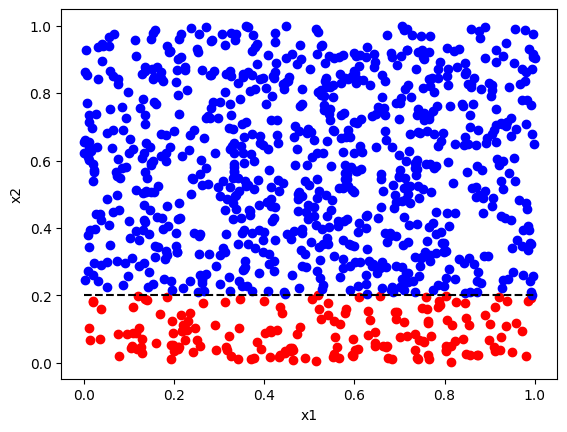

In [55]:
fig, ax = plt.subplots()

for label in [0,1]:
    #filters this sequence of indices by keeping only those where df_d1['y'][i] is equal to label, go first with label 0
    row_ix = [i for i in range(len(df_d1['y'])) if df_d1['y'][i] == label] 
    plt.scatter([df_d1['x1'][i] for i in row_ix], [df_d1['x2'][i] for i in row_ix], c= ['red' if label == 0 else 'blue'])

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.hlines(y= 0.201829, xmin = 0, xmax = 1, linestyles= '--', colors= 'black')
plt.show()

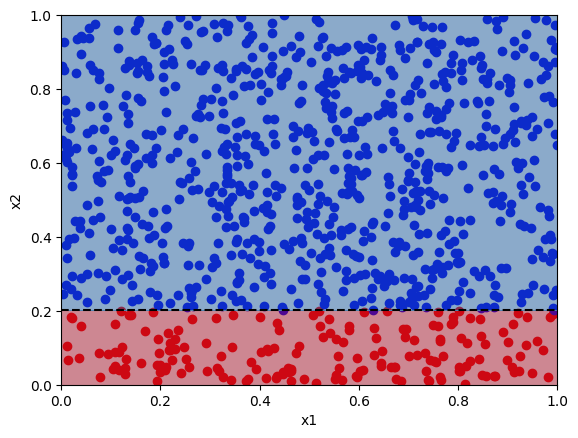

In [56]:
fig, ax = plt.subplots()

for label in [0,1]:
    #filters this sequence of indices by keeping only those where df_d1['y'][i] is equal to label, go first with label 0
    row_ix = [i for i in range(len(df_d1['y'])) if df_d1['y'][i] == label] 
    plt.scatter([df_d1['x1'][i] for i in row_ix], [df_d1['x2'][i] for i in row_ix], c= ['red' if label == 0 else 'blue'])

x1 = np.linspace(0, 1, 3000)
x2 = np.linspace(0, 1, 3000)
#takes two 1-D arrays as inputs and
# returns two 2-D arrays representing all possible combinations of their elements.
x1_grid1, x2_grid1 = np.meshgrid(x1, x2)
z = np.zeros_like(x1_grid1)
for i in range(x1_grid1.shape[0]):
    for j in range(x1_grid1.shape[1]):
        z[i, j] = predict_d1(x1_grid1[i, j], x2_grid1[i, j])
plt.contourf(x1_grid1, x2_grid1, z, cmap='RdBu', alpha=0.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.hlines(y= 0.201829, xmin = 0, xmax = 1, linestyles= '--', colors= 'black')
plt.show()

In [57]:
def predict_d2(x1, x2):
    if x1 >= 0.533076:
        if x1 >= 0.73682:
            if x2 >=  0.210079:
                return 1
            return 0
        elif x1 >= 0.538288:
            if x1 >=  0.542481: 
                if x1 >=  0.548306:
                    if x1 >=  0.645326:
                        if x2 >=  0.301105:
                            return 1
                        return 0
                    elif x1 >=  0.611437:
                        if x2 >=  0.403494:
                            return 1
                        return 0
                    elif x1 >=  0.60386:
                        return 1
                    return 1
                return 1
            elif x2 >=  0.62952:
                return 1
            return 0
        return 1
    elif x2 >= 0.639018:
        if x1 >=  0.111076:
            if x1 >=  0.329959:
                return 1
            return 1
        elif x2 >=  0.964767:
            return 1
        else:
            return 0
    elif x1 >=  0.409972:
        if x2 >=  0.534979:
            if x1 >=  0.426073:
                return 1
            return 1
        return 0
    return 0

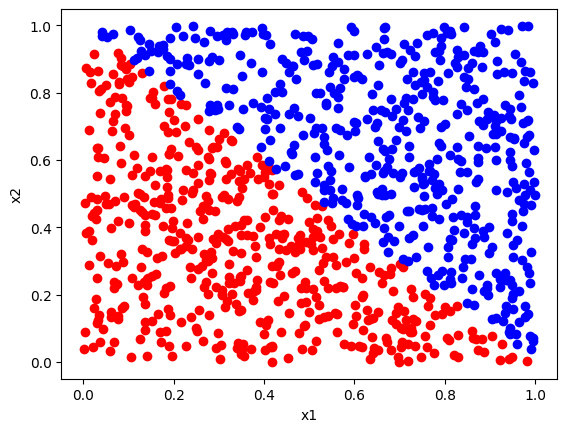

In [58]:
fig, ax = plt.subplots()

for label in [0,1]:
    row_ind = [i for i in range (len(df_d2['y'])) if df_d2['y'][i] == label]
    plt.scatter([df_d2['x1'][row_ind]], [df_d2['x2'][row_ind]], c = 'red' if label == 0 else 'blue')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
plt.show()

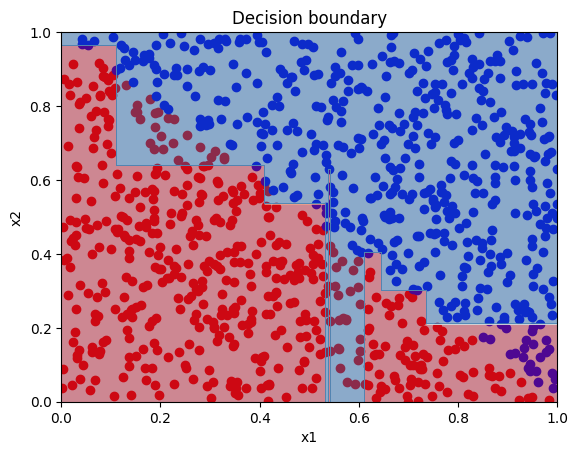

In [71]:
x1 = np.linspace(0, 1, 3000)
x2 = np.linspace(0, 1, 3000)
x1_grid, x2_grid = np.meshgrid(x1, x2)

for label in [0,1]:
    row_ind = [i for i in range (len(df_d2['y'])) if df_d2['y'][i] == label]
    plt.scatter([df_d2['x1'][row_ind]], [df_d2['x2'][row_ind]], c = 'red' if label == 0 else 'blue')
    
# Evaluate the decision tree on each point in the meshgrid
z = np.zeros_like(x1_grid)
for i in range(x1_grid.shape[0]):
    for j in range(x1_grid.shape[1]):
        z[i, j] = predict_d2(x1_grid[i, j], x2_grid[i, j])

# Plot the decision boundary
plt.contourf(x1_grid, x2_grid, z, cmap='RdBu', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision boundary')
plt.show()

In [60]:
dbig = pd.read_csv('data/Dbig.txt', sep= " ", names= colname_d3)

np.random.seed(0)
ind_list = np.random.permutation(10000) #list of 10000 numbers in random numbers

training_ind = ind_list[:8192]
test_ind = ind_list[8192:]
train_set = dbig.loc[training_ind]
test_set = dbig.loc[test_ind]
print(train_set)
print(train_set['y'])

            x1        x2  y
9394  1.319820  1.151578  1
898  -1.222178  0.073686  1
2398 -0.759529  0.921726  0
5906  0.304684 -1.454185  1
2343 -0.775965  0.980504  0
...        ...       ... ..
4104 -0.244451 -1.227159  1
5989  0.329880 -1.459166  1
6537  0.492965 -0.955107  1
540  -1.332802  0.142872  1
80   -1.476813  0.281231  1

[8192 rows x 3 columns]
9394    1
898     1
2398    0
5906    1
2343    0
       ..
4104    1
5989    1
6537    1
540     1
80      1
Name: y, Length: 8192, dtype: int64


In [61]:
train_tree(train_set, 'y')

C:\Users\thong\AppData\Local\Temp\ipykernel_22836\1701759370.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


{'x2 >=  -0.856344': [{'x2 >=  1.232245': [1,
    {'x1 >=  -1.138432': [{'x1 >=  1.135791': [1,
        {'x2 >=  -0.711517': [{'x1 >=  1.06382': [{'x2 >=  0.165721': [{'x2 >=  0.786355': [1,
                {'x1 >=  1.135402': [{'x1 >=  1.135738': [0, 1]},
                  {'x2 >=  0.280301': [0, {'x1 >=  1.10623': [1, 0]}]}]}]},
              1]},
            {'x1 >=  -1.099439': [{'x2 >=  -0.537276': [{'x2 >=  1.220012': [{'x2 >=  1.23018': [0,
                    {'x1 >=  -0.273945': [{'x1 >=  0.474951': [{'x1 >=  0.661497': [1,
                          0]},
                        1]},
                      {'x1 >=  -0.486923': [0, 1]}]}]},
                  {'x1 >=  1.028892': [{'x2 >=  0.143666': [{'x2 >=  0.964307': [1,
                        0]},
                      1]},
                    {'x2 >=  1.198584': [{'x2 >=  1.219689': [0,
                        {'x1 >=  0.719802': [1,
                          {'x1 >=  0.384608': [0,
                            {'x1 >=  -0.29

In [91]:
training_ind_32 = ind_list[:32]
test_ind_32 = ind_list[32:]
train_set32 = dbig.loc[training_ind_32]
test_set32 = dbig.loc[test_ind_32]
train_tree(train_set32, 'y')

C:\Users\thong\AppData\Local\Temp\ipykernel_22836\1701759370.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


{'x2 >=  -0.759475': [{'x1 >=  -0.775965': [{'x1 >=  1.31982': [1,
      {'x2 >=  1.45504': [1,
        {'x2 >=  1.088818': [{'x1 >=  -0.000528': [1, 0]}, 0]}]}]},
    1]},
  1]}

In [85]:
def pred32(x1,x2):
    if x2 >=  -0.759475:
        if x1 >=  -0.775965:
            if x1 >=  1.31982:
                return 1
            elif x2 >=  1.45504:
                return 1
            elif x2 >=  1.088818:
                if x1 >=  -0.000528:
                    return 1
                return 0
            return 0
        return 1
    return 1

In [93]:
train_set32 = train_set32.reset_index()

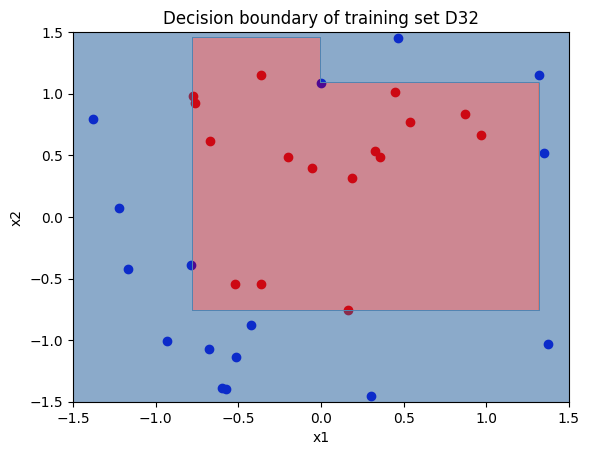

In [97]:
x1 = np.linspace(-1.5, 1.5, 3000)
x2 = np.linspace(-1.5, 1.5, 3000)
x1_grid, x2_grid = np.meshgrid(x1, x2)
for label in [0,1]:
    row_ind = [i for i in range (len(train_set32['y'])) if train_set32['y'][i] == label]
    plt.scatter([train_set32['x1'][row_ind]], [train_set32['x2'][row_ind]], c = 'red' if label == 0 else 'blue')
    
# Evaluate the decision tree on each point in the meshgrid
z = np.zeros_like(x1_grid)
for i in range(x1_grid.shape[0]):
    for j in range(x1_grid.shape[1]):
        z[i, j] = pred32(x1_grid[i, j], x2_grid[i, j])

# Plot the decision boundary
plt.contourf(x1_grid, x2_grid, z, cmap='RdBu', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision boundary of training set D32')
plt.show()

In [104]:
training_ind_128 = ind_list[:128]
test_ind_128 = ind_list[128:]
train_set128 = dbig.loc[training_ind_128]
test_set128 = dbig.loc[test_ind_128]
train_tree(train_set128, 'y')

C:\Users\thong\AppData\Local\Temp\ipykernel_22836\1701759370.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


{'x2 >=  -0.823998': [{'x2 >=  1.151578': [1,
    {'x1 >=  -1.043185': [{'x1 >=  1.16657': [1,
        {'x1 >=  -0.775965': [{'x2 >=  1.088818': [0,
            {'x2 >=  -0.578856': [0, {'x1 >=  0.936977': [1, 0]}]}]},
          {'x1 >=  -0.786045': [1, 0]}]}]},
      1]}]},
  1]}

In [110]:
train_set128 = train_set128.reset_index()

In [100]:
def pred128(x1, x2):
    if x2 >=  -0.823998:
        if x2 >=  1.151578:
            return 1
        elif x1 >=  -1.043185:
            if x1 >=  1.16657:
                return 1
            elif x1 >= -0.775965:
                if x2 >=  1.088818:
                    return 0
                elif x2 >=  -0.578856:
                    return 0
                elif x1 >=  0.936977:
                    return 1
                return 0
            elif x1 >=  -0.786045:
                return 1
            return 0
        return 1
    return 1

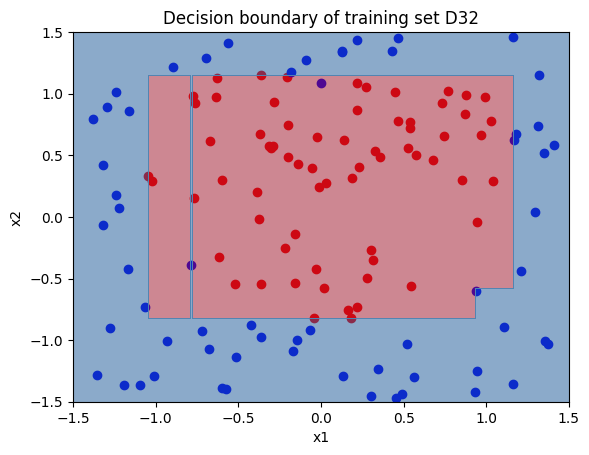

In [119]:
x1 = np.linspace(-1.5, 1.5, 3000)
x2 = np.linspace(-1.5, 1.5, 3000)
x1_grid, x2_grid = np.meshgrid(x1, x2)
for label in [0,1]:
    row_ind = [i for i in range (len(train_set128['y'])) if train_set128['y'][i] == label]
    plt.scatter([train_set128['x1'][row_ind]], [train_set128['x2'][row_ind]], c = 'red' if label == 0 else 'blue')
    
# Evaluate the decision tree on each point in the meshgrid
z = np.zeros_like(x1_grid)
for i in range(x1_grid.shape[0]):
    for j in range(x1_grid.shape[1]):
        z[i, j] = pred128(x1_grid[i, j], x2_grid[i, j])

# Plot the decision boundary
plt.contourf(x1_grid, x2_grid, z, cmap='RdBu', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision boundary of training set D128')
plt.show()

In [117]:
training_ind_512 = ind_list[:512]
test_ind_512 = ind_list[512:]
train_set512 = dbig.loc[training_ind_512]
test_set512 = dbig.loc[test_ind_512]
train_tree(train_set512, 'y')

C:\Users\thong\AppData\Local\Temp\ipykernel_22836\1701759370.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


{'x2 >=  -0.827372': [{'x2 >=  1.220292': [1,
    {'x1 >=  1.113286': [1,
      {'x1 >=  -1.138432': [{'x1 >=  -0.867961': [{'x2 >=  -0.377389': [{'x1 >=  -0.846879': [{'x1 >=  1.030303': [{'x1 >=  1.031688': [0,
                  1]},
                {'x2 >=  1.088818': [{'x1 >=  0.918432': [1,
                    {'x2 >=  1.099944': [{'x2 >=  1.177672': [{'x2 >=  1.181524': [0,
                          1]},
                        0]},
                      1]}]},
                  {'x2 >=  -0.272892': [0, {'x1 >=  0.811319': [1, 0]}]}]}]},
              {'x1 >=  -0.850598': [1, 0]}]},
            {'x1 >=  -0.522247': [{'x1 >=  0.573591': [1,
                {'x2 >=  -0.655145': [0,
                  {'x1 >=  -0.119026': [{'x1 >=  0.375479': [1, 0]}, 1]}]}]},
              1]}]},
          {'x2 >=  0.290925': [{'x2 >=  1.109235': [1,
              {'x1 >=  -1.09737': [0, {'x1 >=  -1.132926': [1, 0]}]}]},
            1]}]},
        1]}]}]},
  {'x2 >=  -0.954911': [{'x2 >=  -0.950828'

In [118]:
train_set512 = train_set512.reset_index()

In [122]:
def pred512(x1, x2):
    if x2 >= -0.827372:
        if x2 >=  1.220292:
            return 1
        elif x1 >=  1.113286:
            return 1
        elif x1 >=  -1.138432:
            if x1 >=  -0.867961:
                if x2 >=  -0.377389:
                    if x1 >=  -0.846879:
                        if x1 >=  1.030303:
                            if x1 >=  1.031688:
                                return 0
                            return 1
                        elif x2 >=  1.088818:
                            if x1 >=  0.918432:
                                return 1
                            elif x2 >=  1.099944:
                                if x2 >=  1.177672:
                                    if x2 >=  1.181524:
                                        return 0
                                    return 1
                                return 1
                            return 1
                        elif x2 >=  -0.272892:
                            return 0
                        elif x1 >=  0.811319:
                            return 1
                        return 0
                    elif x1 >=  -0.850598:
                        return 1
                    return 0
                elif x1 >=  -0.522247:
                    if x1 >=  0.573591:
                        return 1
                    elif x2 >=  -0.655145:
                        return 0
                    elif x1 >=  -0.119026:
                        if x1 >=  0.375479:
                            return 1
                        return 0
                    return 1
                return 1
            elif x2 >=  0.290925:
                if x2 >=  1.109235:
                    return 1
                elif x1 >=  -1.09737:
                    return 0
                elif x1 >=  -1.132926:
                    return 1
                return 0
            return 1
        return 1
    elif x2 >=  -0.954911:
        if x2 >=  -0.950828:
            return 1
        return 0
    return 1

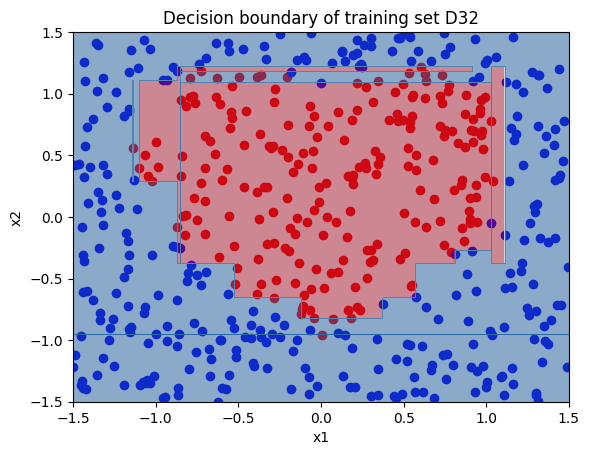

In [123]:
x1 = np.linspace(-1.5, 1.5, 3000)
x2 = np.linspace(-1.5, 1.5, 3000)
x1_grid, x2_grid = np.meshgrid(x1, x2)
for label in [0,1]:
    row_ind = [i for i in range (len(train_set512['y'])) if train_set512['y'][i] == label]
    plt.scatter([train_set512['x1'][row_ind]], [train_set512['x2'][row_ind]], c = 'red' if label == 0 else 'blue')
    
# Evaluate the decision tree on each point in the meshgrid
z = np.zeros_like(x1_grid)
for i in range(x1_grid.shape[0]):
    for j in range(x1_grid.shape[1]):
        z[i, j] = pred512(x1_grid[i, j], x2_grid[i, j])

# Plot the decision boundary
plt.contourf(x1_grid, x2_grid, z, cmap='RdBu', alpha=0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Decision boundary of training set D512')
plt.show()

In [68]:
training_ind_2048 = ind_list[:2048]
test_ind_2048 = ind_list[2048:]
train_set2048 = dbig.loc[training_ind_2048]
test_set2048 = dbig.loc[test_ind_2048]
train_tree(train_set2048, 'y')

C:\Users\thong\AppData\Local\Temp\ipykernel_22836\1701759370.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return func(y, mask)/entropy(mask)


{'x2 >=  -0.856344': [{'x2 >=  1.235216': [1,
    {'x1 >=  1.111265': [1,
      {'x1 >=  -1.138432': [{'x2 >=  -0.604015': [{'x1 >=  -1.102858': [{'x2 >=  1.224725': [{'x2 >=  1.231492': [0,
                1]},
              {'x2 >=  1.198584': [{'x2 >=  1.209165': [{'x1 >=  -0.567575': [{'x1 >=  1.07081': [1,
                      {'x1 >=  0.457856': [0, {'x1 >=  0.251455': [1, 0]}]}]},
                    1]},
                  1]},
                {'x1 >=  1.084733': [{'x1 >=  1.106664': [0,
                    {'x1 >=  1.098132': [0, 1]}]},
                  {'x2 >=  -0.439898': [{'x1 >=  -0.925846': [{'x1 >=  1.081459': [{'x1 >=  1.084163': [0,
                          1]},
                        {'x2 >=  1.088818': [{'x1 >=  0.905577': [1,
                            {'x1 >=  -0.791988': [{'x2 >=  1.098062': [{'x1 >=  0.307208': [0,
                                  {'x1 >=  -0.143302': [1,
                                    {'x1 >=  -0.234924': [{'x2 >=  1.177672': [1,
     